In [ ]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scienceplots
plt.style.use(['science', 'grid'])

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent / "src"))

from phd.config import load_config, copy_config
from phd.models.cm.analytical_plate import (
    train, exact_solution,
    plot_results, plot_compare, animate, subsample_frames, 
    load_run, save_run_data, continue_training, 
)
from phd.plot import book_config
book_config.set_as_current()

# Results directory (uses default: results/analytical_plate/{run_name})
save_fig = True

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

Enable just-in-time compilation with XLA.



## Forward Problem
We train the model to solve the linear elasticity PDE given boundary conditions.

In [ ]:
# Configure and Train Forward Model using Hydra config
from phd.config import copy_config

# Load base config and modify for forward task
cfg_forward_spinn = load_config("analytical_plate")
cfg_forward_spinn.training.n_iter = 50000
cfg_forward_spinn.training.log_every = 200
cfg_forward_spinn.training.lr_decay = ["warmup cosine", 1e-5, 1e-3, 1000, 50000, 1e-5]
cfg_forward_spinn.training.generate_video = False
cfg_forward_spinn.results.save_on_disk = False

# PINN version: copy and modify net_type
cfg_forward_pinn = copy_config(cfg_forward_spinn)
cfg_forward_pinn.model.net_type = "PINN"

results_forward = {}

run_name = "SPINN_forward"
train_model = False
save_run = True

if train_model:
    print("Training Forward Model (SPINN)...")
    results_forward[run_name] = train(cfg_forward_spinn)
    
    if save_run:
        save_run_data(results_forward[run_name], run_name=run_name)
else:
    print(f"Loading existing results for {run_name}...")
    results_forward[run_name] = load_run(run_name)

Loading existing results from analytical_plate_results/SPINN_forward...


W1204 11:38:40.816609 4099438 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1204 11:38:40.820592 4089080 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Forward Results Visualization

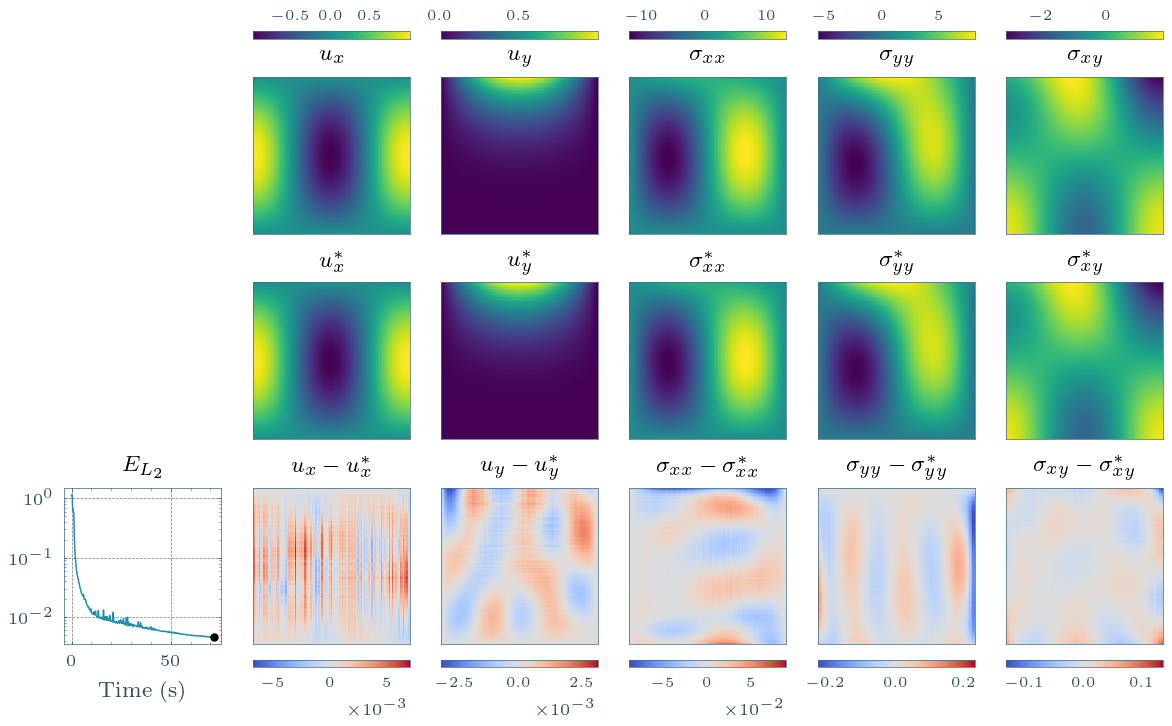

In [ ]:
from ipywidgets import interact, IntSlider

fig, artists = plot_results(results_forward["SPINN_forward"], iteration=-1, dpi=200, step_type="time", time_unit="sec")

# Uncomment to enable interactive plotting
# n_steps = len(results_forward["SPINN_forward"]["field_saver"].history)
# @interact(frame_iter=IntSlider(min=0, max=n_steps-1, step=1, value=n_steps-1))
# def plot_interactive(frame_iter):
#     fig, artists = plot_results(results_forward["SPINN_forward"], iteration=frame_iter, dpi=200)
#     plt.show()

Subsampled from 250 to 106 frames
Animation preview:
  Total available frames: 250
  Selected frames: 106
  FPS: 10
  Duration: 10.6s


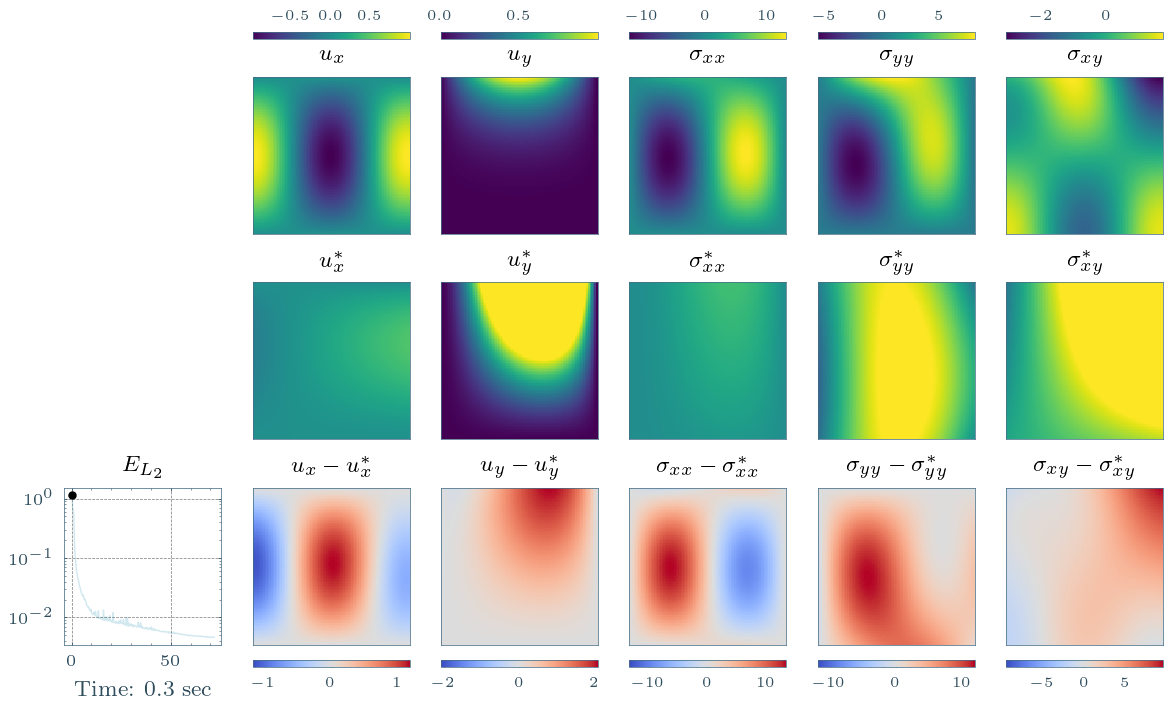

In [ ]:
# Generate Animation
run_dir_forward = Path(results_forward["SPINN_forward"]["run_dir"])
video_path_forward = run_dir_forward / "training_animation.mp4"

# Create figure and artists
fig, artists = plot_results(results_forward["SPINN_forward"], iteration=0, dpi=200, step_type="time", time_unit="sec", show_iter=True)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[1,2,3,4,5,5])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
# animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

In [ ]:
run_name = "PINN_forward"
train_model = False
save_run = True

if train_model:
    print("Training Forward Model (PINN)...")
    results_forward[run_name] = train(cfg_forward_pinn)
    
    if save_run:
        save_run_data(results_forward[run_name], run_name=run_name)
else:
    print(f"Loading existing results for {run_name}...")
    results_forward[run_name] = load_run(run_name)

Loading existing results from analytical_plate_results/PINN_forward...


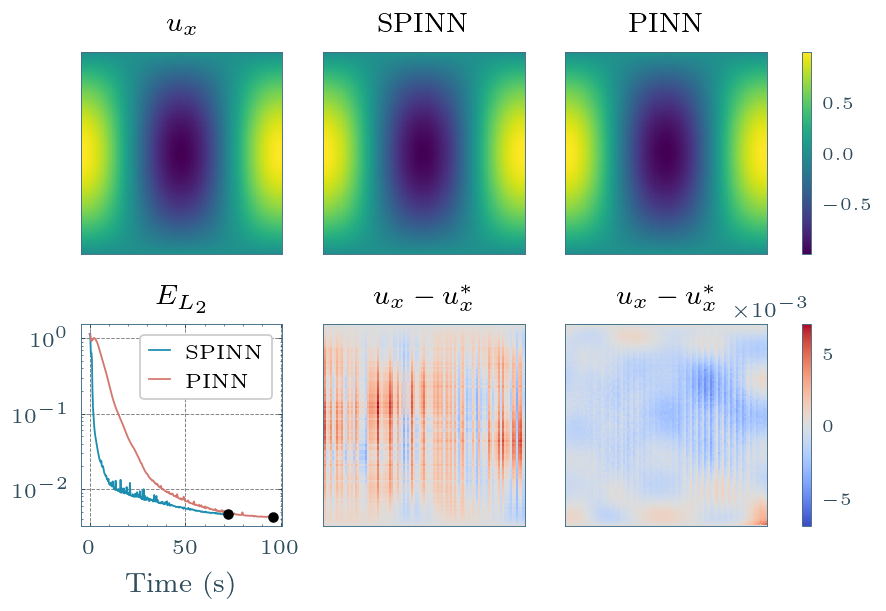

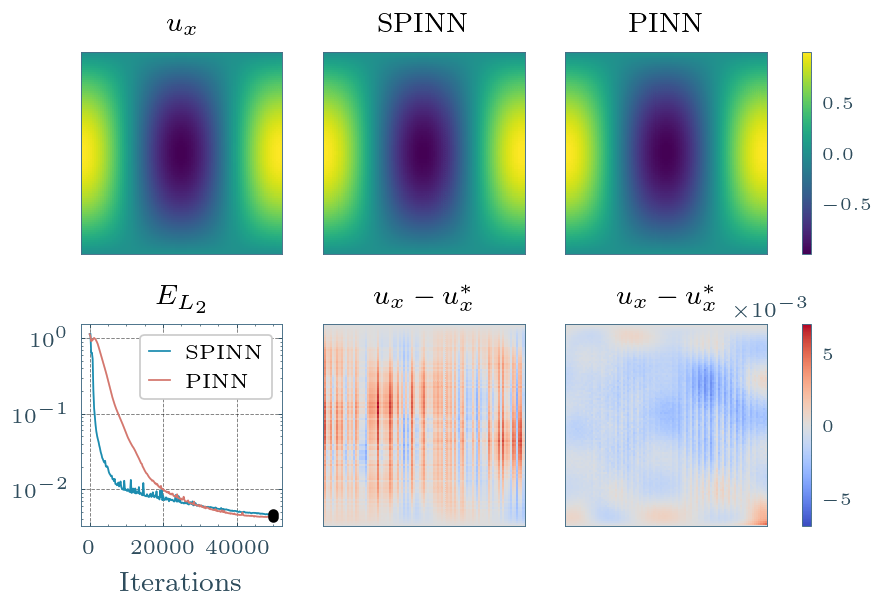

In [ ]:
# Plot comparison between SPINN and PINN
fig, artists = plot_compare(
    results_forward["SPINN_forward"], 
    results_forward["PINN_forward"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
)
if save_fig:
    fig.savefig(results_base_dir / "spinn_vs_pinn_time.png", dpi=300)

fig, artists = plot_compare(
    results_forward["SPINN_forward"], 
    results_forward["PINN_forward"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
)
if save_fig:
    fig.savefig(results_base_dir / "spinn_vs_pinn_iter.png", dpi=300)

In [ ]:
# Generate Animation for comparison
run_dir_forward = Path(results_forward["PINN_forward"]["run_dir"])
video_path_forward = run_dir_forward / "training_animation.mp4"

fig, artists = plot_compare(
    results_forward["SPINN_forward"], 
    results_forward["PINN_forward"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
    show_iter=True
)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[1,2,3,4,4,4,4,4])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
# animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

Subsampled from 250 to 99 frames
Animation preview:
  Total available frames: 250
  Selected frames: 99
  FPS: 10
  Duration: 9.9s
Animation saved to analytical_plate_results/PINN_forward/training_animation.mp4 (99 frames, 9.9s)


## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [ ]:
# Configure and Train Inverse Model using Hydra config
from phd.config import copy_config

# SPINN inverse config
cfg_inverse_spinn = load_config("analytical_plate")
cfg_inverse_spinn.task.type = "inverse"
cfg_inverse_spinn.training.n_iter = 75000
cfg_inverse_spinn.training.log_every = 250
cfg_inverse_spinn.training.lr_decay = ["warmup cosine", 1e-5, 1e-3, 1000, 75000, 1e-5]
cfg_inverse_spinn.training.generate_video = False
cfg_inverse_spinn.results.save_on_disk = False

# PINN inverse config
cfg_inverse_pinn = copy_config(cfg_inverse_spinn)
cfg_inverse_pinn.model.net_type = "PINN"
cfg_inverse_pinn.training.lr_decay = ["warmup cosine", 1e-3, 1e-3, 3000, 75000, 1e-4]

if "results_inverse" not in locals():
    results_inverse = {}

run_name = "SPINN_inverse"
train_model = False
save_run = True

if train_model:
    print("Training Inverse Model (SPINN)...")
    results_inverse[run_name] = train(cfg_inverse_spinn)
    
    if save_run:
        save_run_data(results_inverse[run_name], run_name=run_name)
else:
    print(f"Loading existing results for {run_name}...")
    results_inverse[run_name] = load_run(run_name)

### Inverse Results Visualization

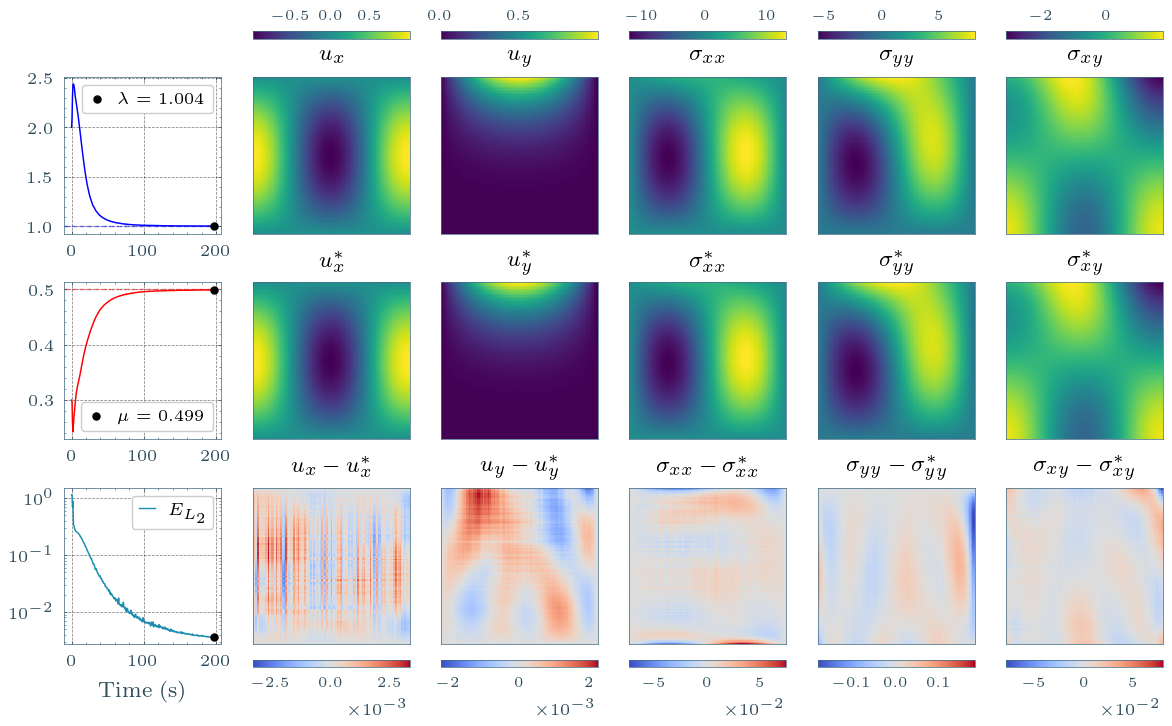

In [ ]:
# Create figure and artists
run_name = "SPINN_inverse" 
step = len(results_inverse[run_name]["losshistory"].steps) - 2
fig_inv, artists_inv = plot_results(results_inverse[run_name], iteration=step, dpi=200, step_type="time", time_unit="sec")

if save_fig:
    run_dir = Path(results_inverse[run_name]["run_dir"])
    fig_inv.savefig(run_dir / "inverse_spinn_75k.png", dpi=300)

In [ ]:
# Generate Animation for Inverse Problem
video_path_inverse = Path(results_inverse[run_name]["run_dir"]) / "training_animation.mp4"
print("Generating animation...")

# Custom frame subsampling - more detail at the beginning
n_frames = len(artists_inv["steps"])
frame_indices = subsample_frames(n_frames, factors=[1, 2, 3, 4, 5, 5, 5])

# Preview
animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices, preview=True)

# Save
fig_inv, artists_inv = plot_results(results_inverse[run_name], iteration=0, dpi=200, step_type="time", time_unit="min", show_iter=True)
animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices)
# Display Inverse Training Animation
Video(video_path_inverse, embed=True, html_attributes="controls loop autoplay")

Generating animation...
Animation preview:
  Total available frames: 300
  Selected frames: 117
  FPS: 10
  Duration: 11.7s
Animation saved to analytical_plate_results/SPINN_inverse/training_animation.mp4 (117 frames, 11.7s)


In [ ]:
run_name = "PINN_inverse"
train_model = False
save_run = True

if train_model:
    print(f"Training Model: {run_name}")
    results_inverse[run_name] = train(cfg_inverse_pinn)

    if save_run:
        save_run_data(results_inverse[run_name], run_name=run_name)
else:
    print(f"Loading existing results for {run_name}...")
    results_inverse[run_name] = load_run(run_name)

Loading existing results from analytical_plate_results/PINN_inverse_enhanced...


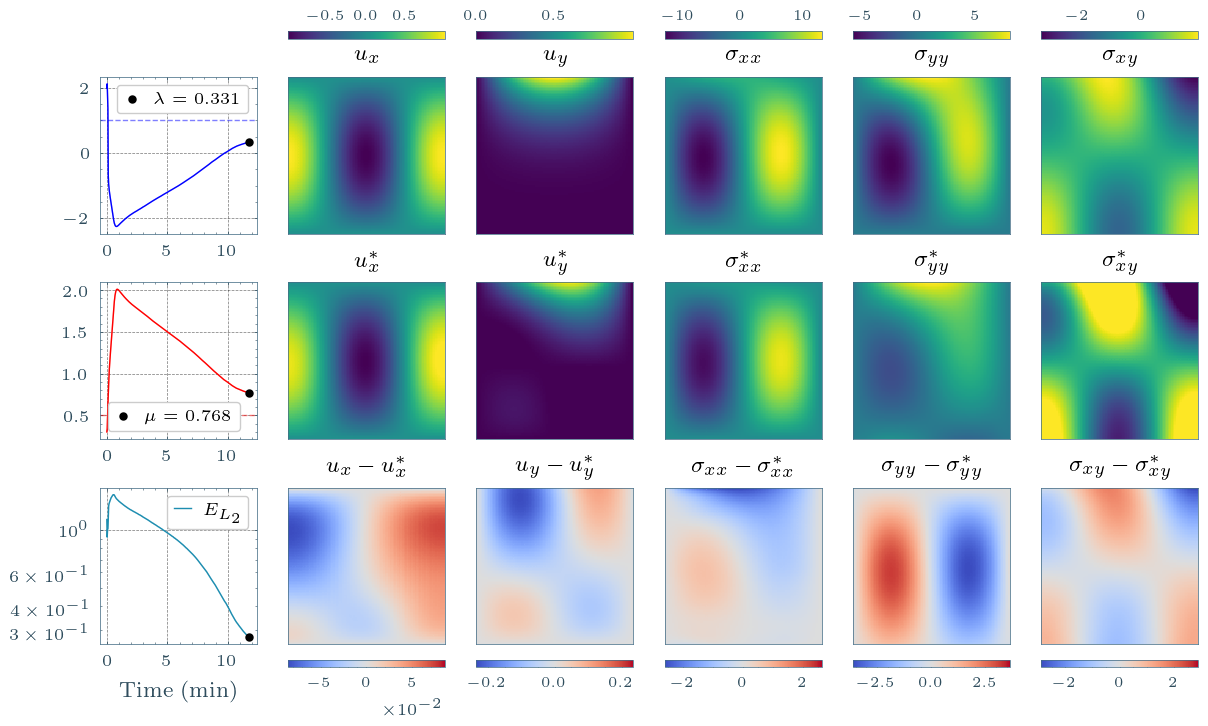

In [ ]:
# Create figure and artists
run_name = "PINN_inverse"

step = -1
fig_inv, artists_inv = plot_results(results_inverse[run_name], iteration=step, dpi=200, step_type="time", time_unit="min")
if save_fig:
    run_dir = Path(results_inverse[run_name]["run_dir"])
    fig_inv.savefig(run_dir / f"inverse_pinn_75k.png", dpi=300)

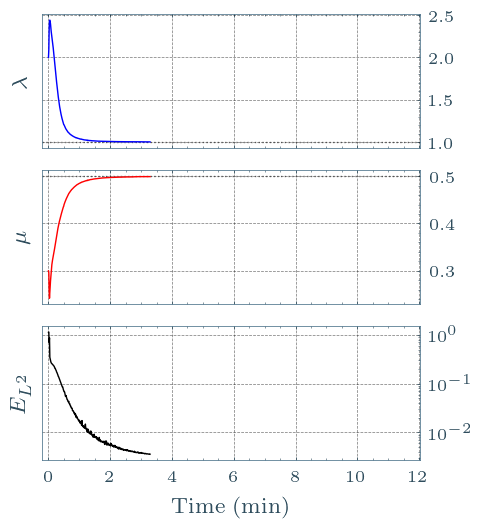

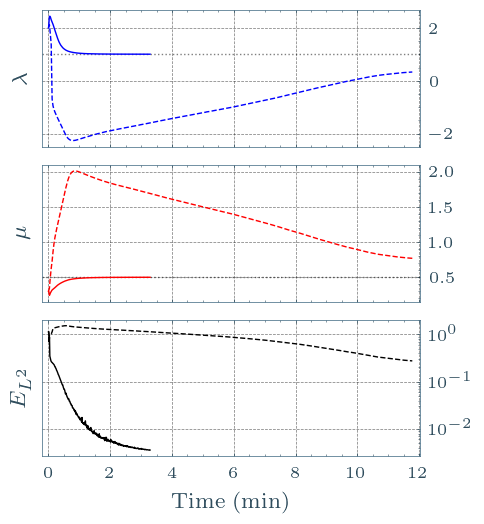

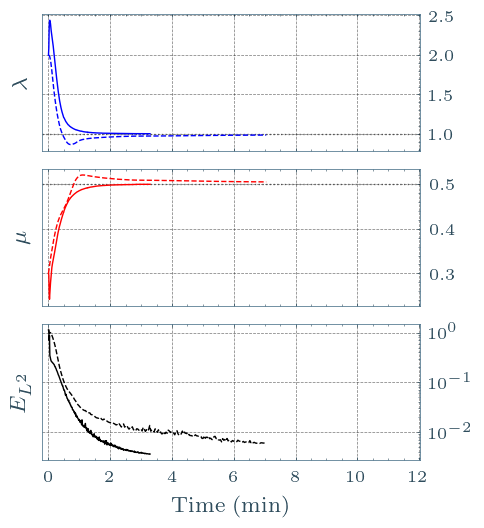

In [ ]:
# Compare parameter evolution: SPINN vs PINN (time-based)
from phd.plot.plot_cm import compute_metrics_from_history

def plot_inverse_evolution(results_data, run_name, ax_lmbd, ax_mu, ax_l2, 
                           lmbd_true=1.0, mu_true=0.5, linestyle='-', color_lmbd='b', color_mu='r'):
    """Plot evolution of lambda, mu and L2 error for a single run.
    
    Returns artists dict containing line and scatter objects for animation.
    """
    d = results_data[run_name]
    elapsed = d.get("elapsed_time", 1.0)
    
    # Get variables history
    var_cb = d.get("variable_value_callback")
    if var_cb and var_cb.history:
        var_hist = np.array(var_cb.history)
        var_steps = var_hist[:, 0]
        lmbd_vals = var_hist[:, 1]
        mu_vals = var_hist[:, 2]
        var_time = var_steps * (elapsed / var_steps[-1]) / 60  # Convert to minutes
    
    # Get metrics history
    metrics = compute_metrics_from_history(d["losshistory"])
    metrics_steps = metrics["steps"]
    l2_vals = metrics["Residual"]
    metrics_time = metrics_steps * (elapsed / metrics_steps[-1]) / 60  # Convert to minutes
    
    # Plot lambda
    ax_lmbd.plot(var_time, lmbd_vals, alpha=0.2, color=color_lmbd)
    lmbd_line, = ax_lmbd.plot([], [], linestyle=linestyle, color=color_lmbd, zorder=3)
    lmbd_scatter = ax_lmbd.scatter([], [], c='k', zorder=4)
    
    # Plot mu
    ax_mu.plot(var_time, mu_vals, alpha=0.2, color=color_mu)
    mu_line, = ax_mu.plot([], [], linestyle=linestyle, color=color_mu, zorder=3)
    mu_scatter = ax_mu.scatter([], [], c='k', zorder=4)
    
    # Plot L2
    ax_l2.plot(metrics_time, l2_vals, alpha=0.2, color=color_lmbd)
    l2_line, = ax_l2.plot([], [], linestyle=linestyle, color=color_lmbd, zorder=3)
    l2_scatter = ax_l2.scatter([], [], c='k', zorder=4)
    
    return {
        "var_time": var_time, "lmbd_vals": lmbd_vals, "mu_vals": mu_vals,
        "metrics_time": metrics_time, "l2_vals": l2_vals,
        "lmbd_line": lmbd_line, "lmbd_scatter": lmbd_scatter,
        "mu_line": mu_line, "mu_scatter": mu_scatter,
        "l2_line": l2_line, "l2_scatter": l2_scatter,
    }


def create_inverse_comparison_figure(spinn_data, pinn_data, 
                                     spinn_run="SPINN_inverse", pinn_run="PINN_inverse",
                                     lmbd_true=1.0, mu_true=0.5,
                                     colors=None, save_path=None):
    """Create a figure comparing SPINN and PINN inverse problem results."""
    from phd.plot import get_current_config, KUL_CYCLE
    
    if colors is None:
        colors = KUL_CYCLE[:2]
    
    # Get elapsed times for axis limits
    spinn_elapsed = spinn_data[spinn_run].get("elapsed_time", 1.0) / 60
    pinn_elapsed = pinn_data[pinn_run].get("elapsed_time", 1.0) / 60
    max_time = max(spinn_elapsed, pinn_elapsed)
    xlim = (0, max_time * 1.05)
    
    # Create figure with 3 rows
    page_width = get_current_config().page_width
    n_subplots = 3
    fig_width_spinn = page_width * 0.5
    axes_width_spinn = fig_width_spinn / n_subplots
    subplot_height = axes_width_spinn
    margin_left = 0.0
    margin_right = 0.0
    x_pad = 0.02 * page_width
    fig_width_both = fig_width_spinn + margin_left + margin_right
    fig_height = subplot_height
    
    fig, axes = plt.subplots(1, n_subplots, figsize=(fig_width_both, fig_height), dpi=200)
    ax_lmbd, ax_mu, ax_l2 = axes
    
    # Plot SPINN
    spinn_art = plot_inverse_evolution(spinn_data, spinn_run, ax_lmbd, ax_mu, ax_l2,
                                       lmbd_true=lmbd_true, mu_true=mu_true,
                                       linestyle='-', color_lmbd=colors[0], color_mu=colors[0])
    
    # Plot PINN
    pinn_art = plot_inverse_evolution(pinn_data, pinn_run, ax_lmbd, ax_mu, ax_l2,
                                      lmbd_true=lmbd_true, mu_true=mu_true,
                                      linestyle='--', color_lmbd=colors[1], color_mu=colors[1])
    
    # Configure lambda axis
    ax_lmbd.axhline(y=lmbd_true, linestyle=':', color='gray', alpha=0.5)
    ax_lmbd.set_xlim(xlim)
    ax_lmbd.set_xlabel("Time (min)")
    ax_lmbd.set_title(r"$\lambda$")
    
    # Configure mu axis
    ax_mu.axhline(y=mu_true, linestyle=':', color='gray', alpha=0.5)
    ax_mu.set_xlim(xlim)
    ax_mu.set_xlabel("Time (min)")
    ax_mu.set_title(r"$\mu$")
    
    # Configure L2 axis
    ax_l2.set_yscale('log')
    ax_l2.set_xlim(xlim)
    ax_l2.set_xlabel("Time (min)")
    ax_l2.set_title(r"$E_{L_2}$")
    
    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=colors[0], linestyle='-', label='SPINN'),
        Line2D([0], [0], color=colors[1], linestyle='--', label='PINN'),
    ]
    ax_l2.legend(handles=legend_elements, loc='upper right', handlelength=1).get_frame().set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, axes


# Load data for comparison
spinn_runs = ["SPINN_forward", "SPINN_inverse"]
pinn_runs = ["PINN_forward", "PINN_inverse"]

spinn_data = {}
for run in spinn_runs:
    try:
        spinn_data[run] = load_run(run)
    except FileNotFoundError:
        print(f"Run {run} not found, skipping...")

pinn_data = {}
for run in pinn_runs:
    try:
        pinn_data[run] = load_run(run)
    except FileNotFoundError:
        print(f"Run {run} not found, skipping...")